In [1]:
import keras 

keras.__version__

Using TensorFlow backend.


'2.2.4'

## 7.2 케라스 콜백과 텐서보드를 사용한 딥러닝 모델 검사와 모니터링

### 7.2.1 콜백을 사용하여 모델의 훈련 과정 제어하기

- https://keras.io/callbacks/

- 모델을 훈련할 때 미리 예상할 수 없는 것들이 많다.

- 특히 최적의 검증 손실을 얻기 위해 얼마나 많은 `epochs`이 필요한지 알지 못한다.

- 케라스의 콜백(`callback`)을 이용해 검증 손실이 더 이상 향상되지 않을 때 훈련을 멈추는 것을 구현할 수 있다.


- 콜백은 모델의 `fit()`메서드가 호출될 때 전달되는 객체다.
    - 훈련하는 동안 모델은 여러 지점에서 콜백을 호출한다. 
    
    - 콜백은 모델의 상태와 성은에 대한 모든 정보에 접근하고 훈련 중지, 모델 저장, 가중치 적재 또는 모델 상태 변경 등을 처리할 수 있다.

- 콜백을 사용하는 몇가지 예제는 다음과 같다.
    - **모델 체크포인트 저장** : 훈련하는 동안 특정 지점에서 모델의 현재 가중치를 저장한다.
    
    - **조기 종료**(early stopping) : 검증 손실이 더 이상 향상되지 않을 때 훈련을 중지한다. 훈련하는 동안 얻은 가장 좋은 모델을 저장한다.
    
    - **훈련하는 동안 하이퍼파라미터 값을 동적으로 조정** : 옵티마이저의 학습률(learning rate) 같은 경우
    
    - **훈련과 검증 지표를 로그에 기록하거나 모델이 학습한 표현이 업데이트될때마다 시각화** : 케라스의 진행 표시줄(progress bar)가 하나의 콜백이다.

#### 1) `ModelCheckpoint`와 `EarlyStopping` 콜백

- `EarlyStopping` 콜백을 사용하면 정해진 epoch 동안 모니터링 지표가 향상되지 않을 때 훈련을 중지할 수 있다.
    
    - 예를 들어, Overfitting이 시작되자마자 훈련을 중지할 수 있다.
    

- 일반적으로 `EarlyStopping` 콜백은 훈련하는 동안 모델을 계속 저장해주는 `ModelCheckpoint`와 함께 사용한다.

    - 선택적으로 지금까지 가장 좋은 모델만 저장할 수 있다.

In [3]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

# fit() 메서드의 callbacks 매개변수를 사용하여 
# callbacks_list를 모델로 전달한다. 몇 개의 콜백이라도 전달할 수 있다.
callbacks_list = [
    EarlyStopping(  # 성능 향상이 멈추면 훈련을 중지한다.
        monitor='val_acc',  # 모델의 검증 정확도를 모니터링 한다. default는 'val_loss'
        patience=1  # 1 epoch보다 더 길게 (즉 2 epoch 동안) 정확도가 향상되지 않으면 훈련이 중지된다. 
    ),
    ModelCheckpoint(  # epoch 마다 현재 가중치를 저장한다.
        filepath='./model/my_model.h5',  # 모델 파일의 경로
        monitor='val_loss',  # 'val_loss'가 좋아지지 않으면 모델 파일을 덮어쓰지 않는다는 뜻
        save_best_only=True  # 훈련하는 동안 가장 좋은 모델만 저장
    )
]

##### MNIST - CNN에 콜백 함수 적용해보기

In [7]:
from keras.datasets import mnist

(train_x, train_y), (test_x, test_y) = mnist.load_data()

train_x = train_x.reshape([-1, 28, 28, 1]) / 255.
test_x = test_x.reshape([-1, 28, 28, 1]) / 255.

In [11]:
from keras import backend as K
from keras import layers, models

K.clear_session()

model = models.Sequential()
model.add(layers.Conv2D(32, 3, padding='same', activation='relu'))
model.add(layers.MaxPooling2D(2))
model.add(layers.Conv2D(64, 3, padding='same', activation='relu'))
model.add(layers.MaxPooling2D(2))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='sparse_categorical_crossentropy',
              metrics=['acc'])  # 정확도를 모니터링하므로 모델 지표에 포함되어야 한다.

# 콜백이 검증 손실(val_loss)과 검증 정확도(val_acc)를 모니터링하기 때문에
# validation_data 또는 validation_split 매개변수를 설정해줘야 한다.
model.fit(train_x, train_y,
          epochs=10,
          batch_size=32,
          callbacks=callbacks_list,  # 콜백함수 리스트 전달
          validation_split=0.2)

Train on 48000 samples, validate on 12000 samples
Epoch 1/10
48000/48000 [==============================] - 45s 931us/step - loss: 0.1339 - acc: 0.9581 - val_loss: 0.0596 - val_acc: 0.9819
Epoch 2/10
48000/48000 [==============================] - 44s 919us/step - loss: 0.0462 - acc: 0.9852 - val_loss: 0.0434 - val_acc: 0.9865
Epoch 3/10
48000/48000 [==============================] - 45s 945us/step - loss: 0.0329 - acc: 0.9899 - val_loss: 0.0348 - val_acc: 0.9902
Epoch 4/10
48000/48000 [==============================] - 46s 966us/step - loss: 0.0250 - acc: 0.9920 - val_loss: 0.0463 - val_acc: 0.9872


#### 2) `ReduceLROnPlateu` 콜백

- `ReduceLROnPlateu` 콜백은 검증 손실(`val_loss`)이 향상되지 않을 때 학습률을 작게 해주는 함수이다.

- 손실(`loss`) 곡선이 평탄할 때 학습률을 작게 하거나 크게 하면 훈련 도중 지역 최소값엣 효과적으로 빠져나올 수 있다.

In [14]:
from keras.callbacks import ReduceLROnPlateau

callbacks_list = [
    ReduceLROnPlateau(
        monitor='val_loss',  # 모델의 검증 손실을 모니터링 한다.
        factor=0.1,  # 콜백이 호출될 때 학습률을 10배로 줄임
        patience=10,   # 검증 손실이 10 epoch동안 좋아지지 않으면 콜백이 호출됨
    )
]

#### 3) 자신만의 콜백 만들기

- 케라스가 제공하는 콜백 말고도 자신만의 콜백을 만들 수 있다. 

- `keras.callbacks.Callback` 클래스를 상속받아 구현한다. - [[링크](https://github.com/keras-team/keras/blob/master/keras/callbacks.py#L148)] 참고


- 훈련하는 동안 호출될 여러 지점을 나타내기 위해 약속된 다음 메서드를 구현한다.

    - `on_epoch_begin` : 각 epoch이 시작할 때 호출한다.

    - `on_epoch_end` : 각 epoch이 끝날 때 호출한다.
    
    - `on_batch_begin` : 각 배치 처리가 시작되기 전에 호출한다.
    
    - `on_batch_end`  : 각 배치 처리가 끝난 후에 호출한다.
    
    - `on_train_begin` : 훈련이 시작될 때 호출한다.
    
    - `on_train_end` : 훈련이 끝날 때 호출한다. 

- 위의 메서드들은 모두 `logs` 매개변수와 함께 호출된다.

    - 이 매개변수에는 이전 배치, epoch에 대한 훈련과 검증 측정값이 담겨있는 **딕셔너리**가 전달된다.
    
    
- 또한, 콜백은 다음 속성을 참조할 수 있다.

    - `self.model` : 콜백을 호출하는 모델 객체
    
    - `self.validation_data` : `fit()` 메서드에 전달된 검증 데이터

- 아래의 예제는 매 epoch의 끝(`on_epoch_end`)에서 검증 세트의 첫 번째 샘플로 모델에 있는 모든 층의 활성화 출력을 계산하여 디스크에 저장하는 콜백의 예제이다.

In [31]:
import keras
import numpy as np


class ActivationLogger(keras.callbacks.Callback):
    
    def set_model(self, model):
        self.model = model
        layer_outputs = [layer.output for layer in model.layers]
        # 각 층의 활성화 출력을 반환하는 Model 객체
        self.activations_model = keras.Model(model.input, layer_outputs)
        
    def on_epoch_end(self, epoch, logs=None):
        if self.validation_data is None:
            raise RuntimeError('Requires validation_data.')
        
        # validation_data의 첫번째 원소는 입력 데이터이고
        # 두번째 원소는 레이블이다.
        validation_sample = self.validation_data[0][0:1]  # 검증 데이터의 첫번째 샘플
        
        activations = self.activations_model.predict(validation_sample)
        activations = [activation.reshape(-1) for activation in activations]
        
        with open('./activations_at_epoch_'+str(epoch)+'.npz', 'wb') as f:
            np.savez(f, activations)

In [32]:
model.fit(train_x, train_y,
          epochs=1,
          batch_size=32,
          callbacks=[ActivationLogger()],  # 콜백함수 리스트 전달
          validation_split=0.2)

Train on 48000 samples, validate on 12000 samples
Epoch 1/1
48000/48000 [==============================] - 41s 864us/step - loss: 0.0025 - acc: 0.9994 - val_loss: 0.0441 - val_acc: 0.9922


### 7.2.2 텐서보드 소개: 텐서플로의 시각화 프레임워크

- 텐서보드(TensorBoard)는 텐서플로 백엔드로 케라스를 설정한 경우에만 모델에서 사용할 수 있다.

- 텐서보드의 목적은 훈련 모델의 내부에서 일어나는 모든 것을 시작적으로 모니터링할 수 있도록 돕는 것이다.

    - 훈련하는 동안 측정 지표를 시각적으로 모니터링 한다.
    
    - 모델 구조를 시각화 한다.
    
    - 활성화 출력과 그래디언트의 히스토그램을 그린다.
    
    - 3D로 임베딩을 표현한다.

#### 텐서보드를 사용한 텍스트 분류 모델

In [1]:
import keras
from keras import layers, models
from keras import backend as K
from keras.datasets import imdb
from keras.preprocessing import sequence

Using TensorFlow backend.


In [2]:
K.clear_session()

max_features = 2000  # 특성으로 사용할 단어의 수
max_len = 500  # 사용할 텍스트의 길이

(train_x, train_y), (test_x, test_y) = imdb.load_data(num_words=max_features)
train_x = sequence.pad_sequences(train_x, maxlen=max_len)
test_x = sequence.pad_sequences(test_x, maxlen=max_len)

In [3]:
model = models.Sequential()
model.add(layers.Embedding(max_features, 64,
                           input_length=max_len,
                           name='embed'))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.MaxPooling1D(5))
model.add(layers.Conv1D(64, 7, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embed (Embedding)            (None, 500, 64)           128000    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 494, 32)           14368     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 98, 32)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 92, 64)            14400     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 156,833
Trainable params: 156,833
Non-trainable params: 0
_________________________________________________________________


In [4]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])

In [5]:
callbacks = [
    keras.callbacks.TensorBoard(
        log_dir='./logs',  # 로그 파일이 기록될 위치
        histogram_freq=1,  # 1 epoch 마다 활성화 출력의 히스토그램을 기록
        embeddings_freq=1, # 1 epoch 마다 임베딩 데이터를 기록 
        embeddings_layer_names=['embed'],
        embeddings_metadata={'embed': 'metadata.tsv'},
        embeddings_data=train_x[:100]
    )
]

In [7]:
history = model.fit(train_x, train_y,
                    epochs=10,
                    batch_size=128, 
                    validation_split=0.2,
                    callbacks=callbacks)

#### 모델 Plotting 하기

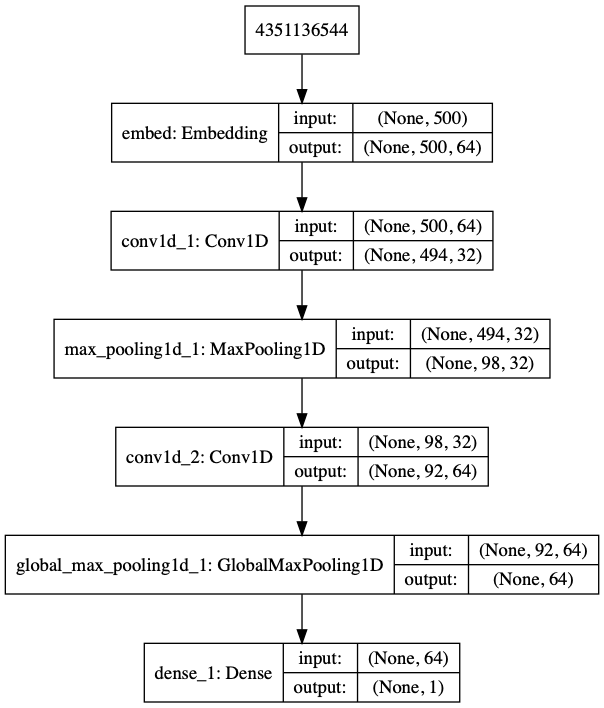

In [8]:
from IPython.display import Image
from keras.utils import plot_model

plot_model(model, show_shapes=True, to_file='./plot-model/conv1d.png')
Image(filename='./plot-model/conv1d.png')

### 7.2.3 정리

- 케라스 콜백은 훈련하는 동안 모델을 모니터링하고 모델 상태를 바탕으로 자동으로 작업을 수행하는 손쉬운 방법이다. 

- 텐서플로를 사용하면 텐서보드를 이용하여 모델 상황을 브라우저에서 시각화할 수 있다. 케라스 모델에서는 TensorBoard 콜백을 통해 사용한다.